# NIPBL
[Cornelia de Lange syndrome-1 (CDLS1)](https://omim.org/entry/122470) is caused by heterozygous mutation in the NIPBL gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.1


## NIPBL
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NIPBL.

In [2]:
gene_symbol = 'NIPBL'
mane_tx_id = 'NM_133433.4'
mane_protein_id = 'NP_597677.2' # nipped-B-like protein isoform A

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.23' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    cdls1_phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=cdls1_phenopackets, 
    cohort_creator=cohort_creator,
)

qc.summarize()

Individuals Processed: 100%|██████████| 60/60 [01:36<00:00,  1.62s/individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
46,Synophrys
42,Global developmental delay
42,Long eyelashes
39,Microcephaly
39,Intrauterine growth retardation
39,Hirsutism
37,Long philtrum
36,Highly arched eyebrow
36,Thin upper lip vermilion
34,Downturned corners of mouth


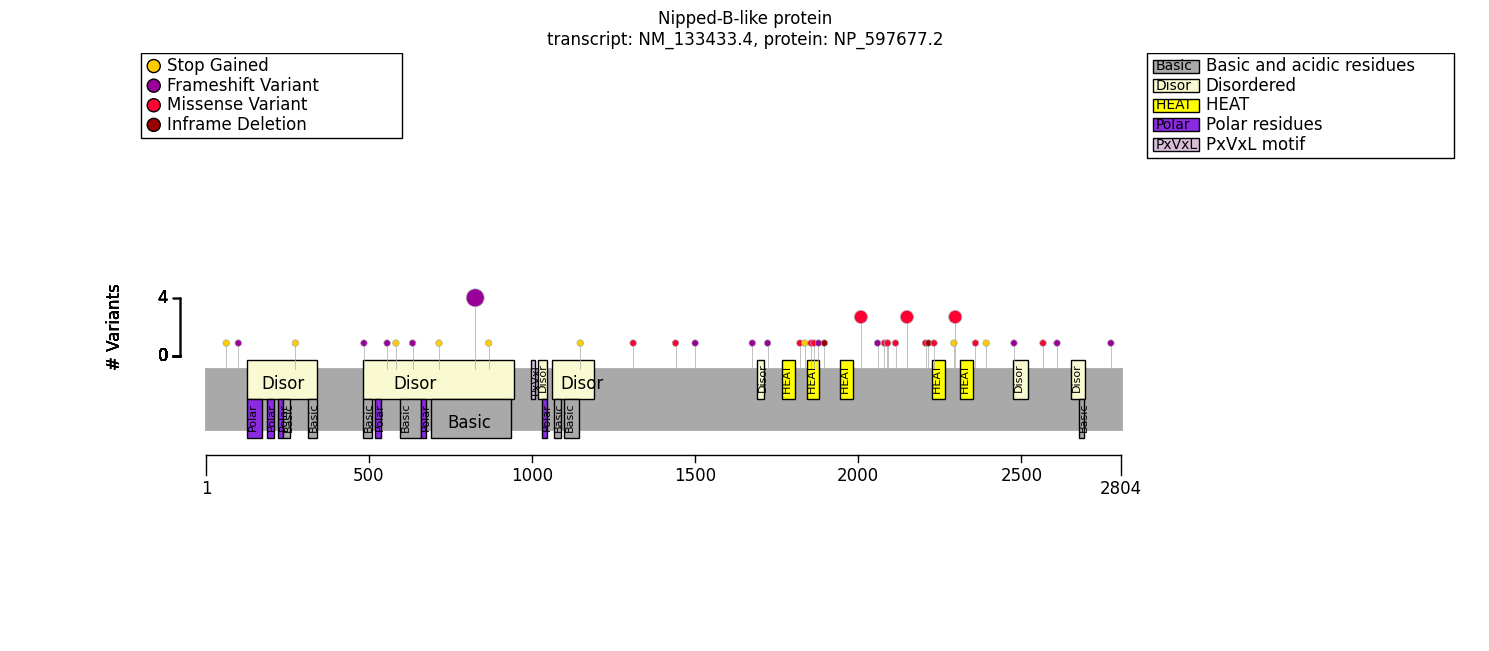

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

nipbl_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
nipbl_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
1,Disordered,Region,129 - 340,p.Gln276Ter
0,Polar residues,Compositional bias,129 - 172,
0,Polar residues,Compositional bias,188 - 210,
0,Polar residues,Compositional bias,224 - 237,
0,Basic and acidic residues,Compositional bias,239 - 259,
0,Basic and acidic residues,Compositional bias,315 - 340,
10,Disordered,Region,483 - 946,p.Arg827GlyfsTer2; p.Arg868Ter; p.Gln716Ter; p.Ser635TyrfsTer3; p.Asp584GlufsTer11; p.Arg827GlyfsTer20; p.Thr558LeufsTer7; p.Glu487Ter
1,Basic and acidic residues,Compositional bias,483 - 510,p.Glu487Ter
0,Polar residues,Compositional bias,520 - 537,
1,Basic and acidic residues,Compositional bias,596 - 659,p.Ser635TyrfsTer3


# Genotype Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

missense = variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense",
    b_label="other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,30
HMF03,Skipping term because of a child term with the same individual counts,19
HMF08,Skipping general term,69
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,144


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Small hand [HP:0200055]                                3/15     20%  24/37   
Hearing impairment [HP:0000365]                        3/13     23%  13/20   
Depressed nasal bridge [HP:0005280]                    6/13     46%  24/30   
Microcephaly [HP:0000252]                              9/13     69%  30/33   
Delayed speech and language development [HP:000...      6/9     67%  23/26   
...                                                     ...     ...    ...   
Language impairment [HP:0002463]                        6/6    100%  23/23   
Abnormal communication [HP:0034434]                     6/6    100%  23/23   
Abnormal speech pattern [HP:0002167]                    6/6    100%  23/23   
Aplasia/Hypoplasia of the mandible [HP:0009118]         7/7    100%  20/20   
Intellectual disability [HP:0001249]                  10/12     83%  24/28   

Allele group                                                                   \
                                                   Percent Corrected p values   
Small hand [HP:0200055]                                65%           0.370138   
Hearing impairment [HP:0000365]                        65%           0.856654   
Depressed nasal bridge [HP:0005280]                    80%           0.856654   
Microcephaly [HP:0000252]                              91%           1.000000   
Delayed speech and language development [HP:000...     88%           1.000000   
...                                                    ...                ...   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Abnormal speech pattern [HP:0002167]                  100%           1.000000   
Aplasia/Hypoplasia of the mandible [HP:0009118]       100%           1.000000   
Intellectual disability [HP:0001249]                   86%           1.000000   

Allele group                                                  
                                                    p values  
Small hand [HP:0200055]                             0.005288  
Hearing impairment [HP:0000365]                     0.032361  
Depressed nasal bridge [HP:0005280]                 0.036714  
Microcephaly [HP:0000252]                           0.086669  
Delayed speech and language development [HP:000...  0.161851  
...                                                      ...  
Language impairment [HP:0002463]                    1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Abnormal speech pattern [HP:0002167]                1.000000  
Aplasia/Hypoplasia of the mandible [HP:0009118]     1.000000  
Intellectual disability [HP:0001249]                1.000000  

[70 rows x 6 columns]

In [10]:
from gpsea.analysis.predicate import protein_feature

disordered = protein_feature(feature_id="Disordered", protein_metadata=protein_meta)
disordered_clf = missense_predicate = monoallelic_classifier (
    a_predicate=disordered,
    b_predicate=~disordered,
    a_label="disordered",
    b_label="other"
)
disordered_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=disordered_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=disordered_result)

Allele group                                    disordered          other  \
                                                     Count Percent  Count   
Intrauterine growth retardation [HP:0001511]         10/10    100%  29/42   
Curly eyelashes [HP:0007665]                           6/9     67%  27/30   
Single transverse palmar crease [HP:0000954]           5/5    100%  15/27   
Limited elbow extension [HP:0001377]                   4/6     67%   8/28   
Short stature [HP:0004322]                             4/6     67%  29/32   
...                                                    ...     ...    ...   
Language impairment [HP:0002463]                       7/7    100%  22/22   
Abnormal communication [HP:0034434]                    7/7    100%  22/22   
Abnormal speech pattern [HP:0002167]                   7/7    100%  22/22   
Aplasia/Hypoplasia of the mandible [HP:0009118]        6/6    100%  21/21   
Intellectual disability [HP:0001249]                  9/10     90%  25/30   

Allele group                                                                \
                                                Percent Corrected p values   
Intrauterine growth retardation [HP:0001511]        69%                1.0   
Curly eyelashes [HP:0007665]                        90%                1.0   
Single transverse palmar crease [HP:0000954]        56%                1.0   
Limited elbow extension [HP:0001377]                29%                1.0   
Short stature [HP:0004322]                          91%                1.0   
...                                                 ...                ...   
Language impairment [HP:0002463]                   100%                1.0   
Abnormal communication [HP:0034434]                100%                1.0   
Abnormal speech pattern [HP:0002167]               100%                1.0   
Aplasia/Hypoplasia of the mandible [HP:0009118]    100%                1.0   
Intellectual disability [HP:0001249]                83%                1.0   

Allele group                                               
                                                 p values  
Intrauterine growth retardation [HP:0001511]     0.050161  
Curly eyelashes [HP:0007665]                     0.122513  
Single transverse palmar crease [HP:0000954]     0.130085  
Limited elbow extension [HP:0001377]             0.154142  
Short stature [HP:0004322]                       0.168956  
...                                                   ...  
Language impairment [HP:0002463]                 1.000000  
Abnormal communication [HP:0034434]              1.000000  
Abnormal speech pattern [HP:0002167]             1.000000  
Aplasia/Hypoplasia of the mandible [HP:0009118]  1.000000  
Intellectual disability [HP:0001249]             1.000000  

[74 rows x 6 columns]

In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Clinodactyly [HP:0030084]                            6/12     50%  15/17   
Finger clinodactyly [HP:0040019]                     5/11     45%  13/15   
Intrauterine growth retardation [HP:0001511]        17/19     89%  18/28   
Long eyelashes [HP:0000527]                         10/12     83%  24/24   
Micrognathia [HP:0000347]                           13/18     72%  13/27   
...                                                   ...     ...    ...   
Delayed speech and language development [HP:000...  11/13     85%  18/22   
Language impairment [HP:0002463]                    11/11    100%  18/18   
Abnormal communication [HP:0034434]                 11/11    100%  18/18   
Abnormal speech pattern [HP:0002167]                11/11    100%  18/18   
Aplasia/Hypoplasia of the mandible [HP:0009118]     13/13    100%  13/13   

Sex                                                                            \
                                                   Percent Corrected p values   
Clinodactyly [HP:0030084]                              88%                1.0   
Finger clinodactyly [HP:0040019]                       87%                1.0   
Intrauterine growth retardation [HP:0001511]           64%                1.0   
Long eyelashes [HP:0000527]                           100%                1.0   
Micrognathia [HP:0000347]                              48%                1.0   
...                                                    ...                ...   
Delayed speech and language development [HP:000...     82%                1.0   
Language impairment [HP:0002463]                      100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Abnormal speech pattern [HP:0002167]                  100%                1.0   
Aplasia/Hypoplasia of the mandible [HP:0009118]       100%                1.0   

Sex                                                           
                                                    p values  
Clinodactyly [HP:0030084]                           0.038194  
Finger clinodactyly [HP:0040019]                    0.038444  
Intrauterine growth retardation [HP:0001511]        0.087457  
Long eyelashes [HP:0000527]                         0.104762  
Micrognathia [HP:0000347]                           0.134109  
...                                                      ...  
Delayed speech and language development [HP:000...  1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Abnormal speech pattern [HP:0002167]                1.000000  
Aplasia/Hypoplasia of the mandible [HP:0009118]     1.000000  

[67 rows x 6 columns]

# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=disordered_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result
    ),
)

caption = "No statistically significant genotype-phenotype correlation identified."

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,70,0
Genotype (A),Genotype (B),Tests performed,Significant tests
disordered,other,74,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,67,0


In [14]:
summarizer.process_latex(report=report, protein_fig=nipbl_fig)

Figure saved to ../../supplement/img/NIPBL_protein_diagram-draft.pdf
Output to ../../supplement/tex/NIPBL_summary_draft.tex
